# ウェブサービスにおけるデータサイエンス実践 第5回

## データ分析の実務プロセスと探索的データ解析

## 今日の目的

- いろいろな可視化方法を知る
- それぞれの活用方法を学ぶ

In [1]:
%matplotlib inline
import sqlite3

import pandas
import matplotlib.pyplot as pyplot

In [2]:
sqlite_conn = sqlite3.connect('../resources/waseda.db')

## 棒グラフ

- 大きさの比を見る
- 大きさの比をみるのが目的なので、軸の一部を省略してはいけない

In [6]:
sql = """
SELECT
    gender_id,
    COUNT(user_id) as count
FROM
    users
GROUP BY 
    gender_id
"""

df = pandas.read_sql(sql, sqlite_conn)

In [14]:
df

,gender_id,count
0,NaN,1152
1,0.0,4831
2,1.0,4017


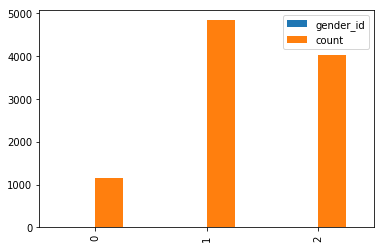

In [26]:
# kind='bar'で棒グラフにできる
# これだとよくわからない
df.plot(kind='bar')

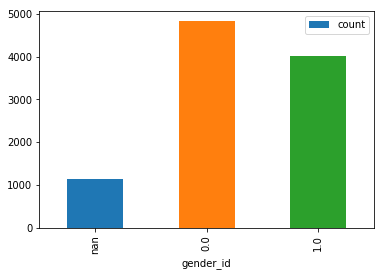

In [24]:
# ちゃんとどのカラムを軸に比較するのかを示す
df.plot(kind='bar', y='count', x='gender_id')

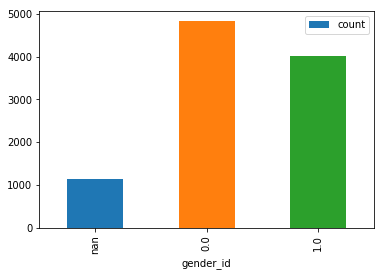

In [25]:
# plot.barでもkind='bar'と同じ意味になる
df.plot.bar( y='count', x='gender_id')

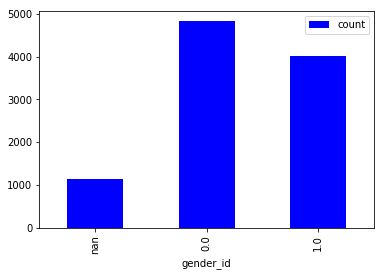

In [18]:
df.plot.bar( y='count', x='gender_id', color='blue')

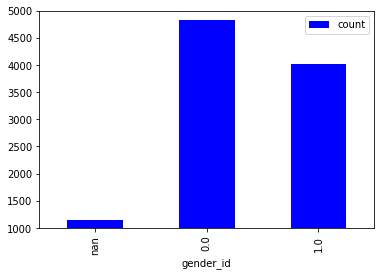

In [22]:
# だめな例
# 比を誤って解釈してしまう
df.plot.bar( y='count', x='gender_id', color='blue', ylim=[1000, 5000])

In [ ]:
# 男女別に各日の登録人数を棒グラフにしてみたい
# こんなDFを作りたい
#                           male_count       female_count
# yy/mm/dd           xxxxx                 xxxxx
# yy/mm/dd           xxxxx                 xxxxx

In [29]:
sql = """
SELECT
    DATE(created_at) as date,
    COUNT(
        CASE WHEN gender_id = 0 THEN 1 ELSE NULL END
    ) as male_count,
    COUNT(
        CASE WHEN gender_id = 1 THEN 1 ELSE NULL END
    ) as female_count 
FROM
    users
GROUP BY
    DATE(created_at)
"""

df =  pandas.read_sql(sql, sqlite_conn)

In [30]:
df

,date,male_count,female_count
0,2019-03-18,673,501
1,2019-03-19,708,664
2,2019-03-20,698,661
3,2019-03-21,820,672
4,2019-03-22,526,477
5,2019-03-23,718,565
6,2019-03-24,688,477


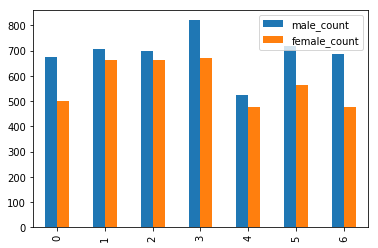

In [31]:
df.plot(kind='bar')

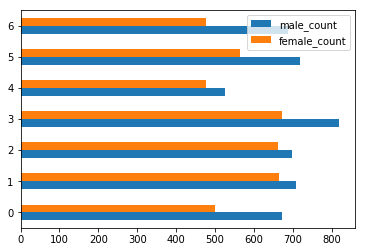

In [32]:
df.plot(kind='barh')

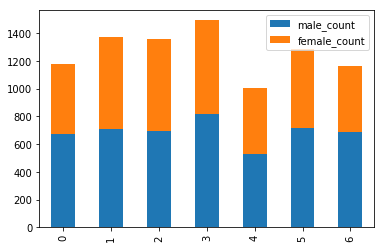

In [34]:
# 積上げの棒グラフ
# 各日の男女比と、日別の登録人数の比を同時に見れる
# 各日の男性の比とか、女性の比をみるのは向いていない
df.plot(kind='bar', stacked=True)

## ヒストグラム

- 分布をみるための可視化手法のひとつ
    - データにどの程度ばらつきがあるのか
    - どの範囲にデータが集まっているのか
- 横軸に階級（データの範囲）、縦軸に度数（データの頻度）をとる

In [35]:
sql = """
SELECT
    user_id,
    COUNT(article_id) as count
FROM
    clicks
GROUP BY
    user_id
"""

df =  pandas.read_sql(sql, sqlite_conn)

In [37]:
df.head()

,user_id,count
0,1,3
1,2,2
2,3,3
3,4,7
4,5,1


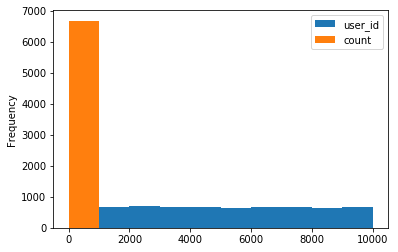

In [43]:
df.plot(kind='hist')

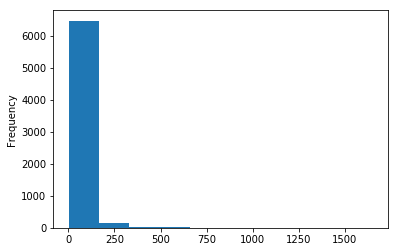

In [45]:
# ヒストグラムはある変数に対するものなのでこうなる
# 変数指定
df['count'].plot(kind='hist')

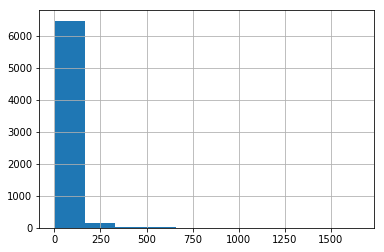

In [46]:
# .histがつかえる
df['count'].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120207da0>,
      dtype=object)

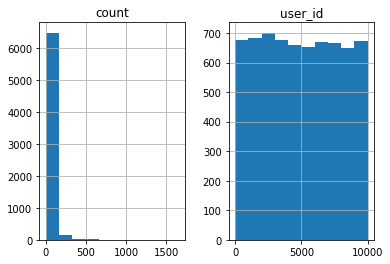

In [48]:
# DataFrameに対する .histは少し挙動が異なる
# ふたつのグラフができる
df.hist()

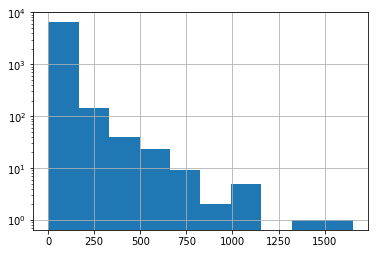

In [51]:
# 分布が偏ってるので対数軸をとってみる
df['count'].hist(log=True)

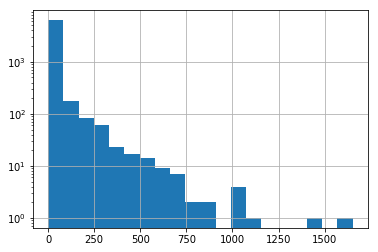

In [52]:
# 細かくしてみる
df['count'].hist(log=True, bins=20)

In [78]:
sql = """
SELECT
    users.user_id,
    users.gender_id,
    COUNT(article_id) as count
FROM
    clicks
JOIN
    users
ON
    clicks.user_id = users.user_id
GROUP BY
    users.user_id,
    users.gender_id
"""

df =  pandas.read_sql(sql, sqlite_conn)

In [54]:
df.head()

,user_id,gender_id,count
0,1,1.0,3
1,2,1.0,2
2,3,0.0,3
3,4,1.0,7
4,5,1.0,1


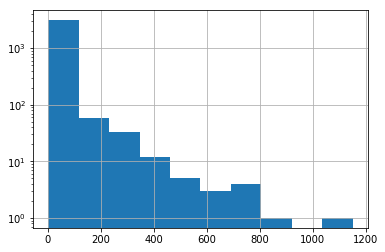

In [56]:
df[df['gender_id'] == 0]['count'].hist(log=True)

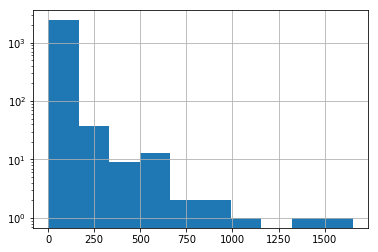

In [57]:
df[df['gender_id'] == 1]['count'].hist(log=True)

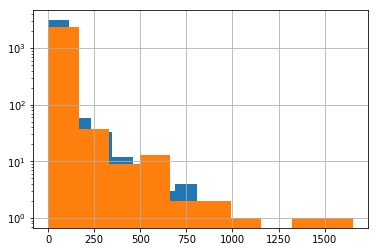

In [58]:
# 重ねる
df[df['gender_id'] == 0]['count'].hist(log=True)
df[df['gender_id'] == 1]['count'].hist(log=True)

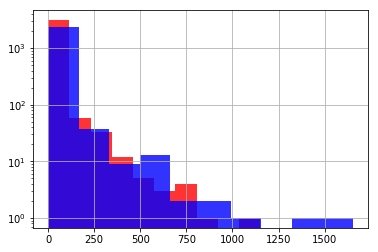

In [61]:
# 透明化
df[df['gender_id'] == 0]['count'].hist(log=True, alpha=0.8, color='red')
df[df['gender_id'] == 1]['count'].hist(log=True, alpha=0.8, color='blue')

## 箱ひげ図

- 五数要約
    - 最小値
    - 下位25%
    - 中央値
    - 上位25%
    - 最大値
    
- ヒストグラムより大雑把にしかみれない
- ヒストグラムはデータの種類が大きいと見づらいので、3種以上の比較なら箱ひげ図

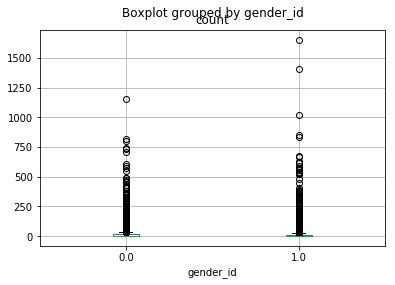

In [79]:
# 男女別クリック数やってみるけど
# 分布の偏りが大きいからよくわかんないね！
df.boxplot(by='gender_id', column=['count'])

In [72]:
sql = """
SELECT
    users.user_id,
    users.gender_id,
    COUNT(DISTINCT DATE(clicks.created_at)) as count
FROM
    users
LEFT OUTER JOIN
    clicks
ON
    clicks.user_id = users.user_id
GROUP BY
    users.user_id,
    users.gender_id
"""

df =  pandas.read_sql(sql, sqlite_conn)

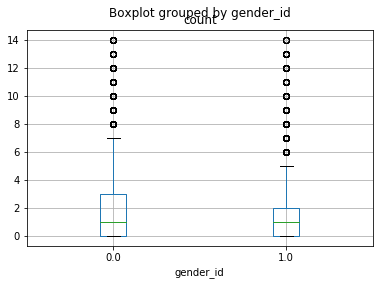

In [74]:
# ログイン日数にしてみる
df.boxplot(by='gender_id', column=['count'])

## 散布図

- 2つの量的変数の関係をみる
- XとYで別の変数をとり、データを点として表現する
- いわゆる相関関係を可視化する
     - 今回渡しているデータだとあまりいいのが出ない

In [88]:
sql = """
WITH firstday_clicks as (
    SELECT
        users.user_id,
        COUNT(article_id) as num
    FROM
        users
    LEFT OUTER JOIN
        clicks
    ON 
        users.user_id = clicks.user_id
    WHERE
        DATE(clicks.created_at) = DATE(users.created_at)
    GROUP BY
        users.user_id
),
click_days as (
    SELECT
        user_id,
        COUNT(DISTINCT DATE(created_at)) as num
    FROM
        clicks
    GROUP BY
        user_id
)
SELECT
    f.user_id as user_id,
    f.num as firstday_clicks,
    CASE WHEN d.num is NULL THEN 0 ELSE d.num END as click_days
FROM
    firstday_clicks as f
LEFT OUTER JOIN
    click_days as d
ON
    f.user_id = d.user_id
"""

df =  pandas.read_sql(sql, sqlite_conn)

In [89]:
df.head()

,user_id,firstday_clicks,click_days
0,1,1,2
1,4,6,2
2,5,1,1
3,6,3,2
4,9,5,1


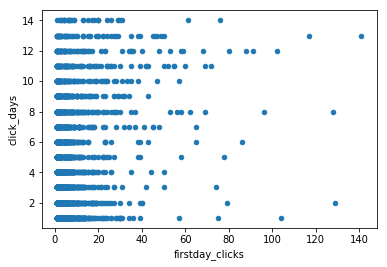

In [93]:
df.plot(kind='scatter', x='firstday_clicks', y='click_days')

## 折れ線グラフ

- 時系列の変化をみるのにつかう
- 時系列の変化出ない場合は適切ではない -> 散布図などにすべき
- 変動比をみるためのもののため、縦軸は省略して構わないことも多い -> 棒グラフとは違う

In [95]:
sql = """
WITH registrations as (
    SELECT
        DATE(created_at) as date,
        COUNT(user_id) as num
    FROM
        users
    GROUP BY
        DATE(created_at)
),
click_uu as (
    SELECT 
        DATE(clicks.created_at) as date,
        DATE(users.created_at) as registration_date,
        COUNT(distinct clicks.user_id) as num
    FROM
        clicks
    JOIN
        users
    ON
        clicks.user_id = users.user_id
    GROUP BY
        DATE(clicks.created_at),
        DATE(users.created_at)
),
registrations_and_clicks as (
    SELECT
        JULIANDAY(click_uu.date) - JULIANDAY(click_uu.registration_date) as continue_days,
        click_uu.date,
        click_uu.registration_date,
        registrations.num as registration_num,
        click_uu.num as click_uu
    FROM
        registrations
    JOIN
        click_uu
    ON
        registrations.date = click_uu.registration_date
)
SELECT
    continue_days,
    SUM(registration_num),
    SUM(click_uu),
    1.0 * SUM(click_uu) / SUM(registration_num) as rate
FROM 
    registrations_and_clicks
GROUP BY
    continue_days
"""


df = pandas.read_sql(sql, sqlite_conn)

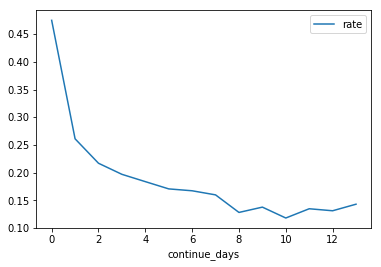

In [97]:
df.plot(x='continue_days', y='rate')

## 帯グラフ

- pandasだと難しい -> 棒グラフを合計が1になるように作る

In [151]:
sql = """
SELECT
    DATE(created_at) as date,
    COUNT(
        CASE WHEN gender_id = 0 THEN 1 ELSE NULL END
    ) as male_count,
    COUNT(
        CASE WHEN gender_id = 1 THEN 1 ELSE NULL END
    ) as female_count 
FROM
    users
GROUP BY
    DATE(created_at)
"""

df =  pandas.read_sql(sql, sqlite_conn)

In [152]:
df

,date,male_count,female_count
0,2019-03-18,673,501
1,2019-03-19,708,664
2,2019-03-20,698,661
3,2019-03-21,820,672
4,2019-03-22,526,477
5,2019-03-23,718,565
6,2019-03-24,688,477


In [153]:
df['male_rate'] = df['male_count']/(df['male_count']+df['female_count'])
df['female_rate'] = df['female_count']/(df['male_count']+df['female_count'])

In [154]:
df

,date,male_count,female_count,male_rate,female_rate
0,2019-03-18,673,501,0.573254,0.426746
1,2019-03-19,708,664,0.516035,0.483965
2,2019-03-20,698,661,0.513613,0.486387
3,2019-03-21,820,672,0.549598,0.450402
4,2019-03-22,526,477,0.524427,0.475573
5,2019-03-23,718,565,0.559626,0.440374
6,2019-03-24,688,477,0.590558,0.409442


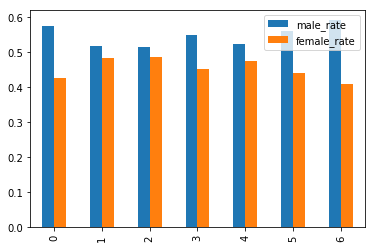

In [155]:
df.plot(kind='bar', y=['male_rate', 'female_rate'])

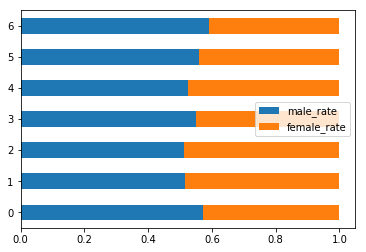

In [156]:
df.plot(kind='barh', y=['male_rate', 'female_rate'], stacked=True)

In [157]:
sql = """
SELECT
    COUNT(
        CASE WHEN gender_id = 0 THEN 1 ELSE NULL END
    ) as male_count,
    COUNT(
        CASE WHEN gender_id = 1 THEN 1 ELSE NULL END
    ) as female_count 
FROM
    users
"""

df =  pandas.read_sql(sql, sqlite_conn)

In [158]:
df['male_rate'] = df['male_count']/(df['male_count']+df['female_count'])
df['female_rate'] = df['female_count']/(df['male_count']+df['female_count'])

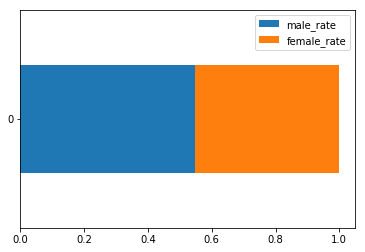

In [159]:
df.plot(kind='barh', y=['male_rate', 'female_rate'], stacked=True)